In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import STL
from pmdarima import arima
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df_holidays = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_stores = pd.read_csv('stores.csv')
df_trans = pd.read_csv('transactions.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
#datetime形に変換
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] =  pd.to_datetime(df_oil['date'])
df_trans['date'] =  pd.to_datetime(df_trans['date'])
df_train['date'] =  pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [4]:
holiday=df_holidays.query('type=="Holiday"')
holiday=pd.DataFrame(holiday[['date','type']])
#holidayの中の重複行を抽出
holiday[holiday.duplicated()]
#holiday.query('date=="2014-07-03"')
#holiday.duplicated().value_counts() 重複行数のカウント

,date,type
8,2012-06-25,Holiday
9,2012-06-25,Holiday
11,2012-07-03,Holiday
59,2013-06-25,Holiday
60,2013-06-25,Holiday
62,2013-07-03,Holiday
111,2014-06-25,Holiday
112,2014-06-25,Holiday
119,2014-07-03,Holiday
177,2015-06-25,Holiday


In [5]:
#重複行を削除
holiday=holiday.drop_duplicates()
holiday.duplicated().value_counts()

False    202
dtype: int64

<AxesSubplot:>

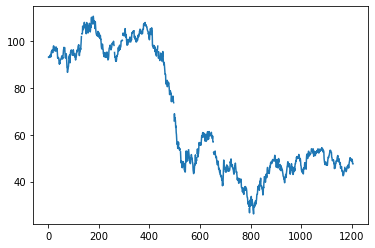

In [6]:
df_oil.loc[0:1205,:]['dcoilwtico'].plot()

In [7]:
date_pre=pd.date_range(start='2013-01-01', end='2017-08-15')
date=pd.DataFrame(date_pre, columns=['date'])
date

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1683,2017-08-11
1684,2017-08-12
1685,2017-08-13
1686,2017-08-14


In [8]:
df_oil2=pd.merge(date, df_oil, on='date', how='left')
df_oil2

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
...,...,...
1683,2017-08-11,48.81
1684,2017-08-12,NaN
1685,2017-08-13,NaN
1686,2017-08-14,47.59


In [9]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [11]:
df_train.groupby('family').sum()

,id,store_nbr,sales,onpromotion
family,,,,
AUTOMOTIVE,136442875140,2500740,5.548220e+05,4783
BABY CARE,136442966076,2500740,1.005100e+04,53
BEAUTY,136443057012,2500740,3.378930e+05,13483
BEVERAGES,136443147948,2500740,2.169545e+08,906958
BOOKS,136443238884,2500740,6.438000e+03,0
BREAD/BAKERY,136443329820,2500740,4.213395e+07,331289
CELEBRATION,136443420756,2500740,7.611770e+05,6723
CLEANING,136443511692,2500740,9.752129e+07,661157
DAIRY,136443602628,2500740,6.448771e+07,728707


In [12]:
df_train_grocery1=df_train.query('family == "GROCERY I"').groupby('date').agg({'sales':'sum'})
#df_train.query('family == "GROCERY I"').groupby('store_nbr').agg({'sales':'sum'})
df_train_grocery1=df_train_grocery1.rename(columns={'sales':'grocery1_sales_sum'})
df_train_grocery1

,grocery1_sales_sum
date,
2013-01-01,700.000
2013-01-02,202020.000
2013-01-03,144878.000
2013-01-04,135754.000
2013-01-05,188356.000
...,...
2017-08-11,238221.922
2017-08-12,238627.633
2017-08-13,258442.452


In [13]:
null=pd.merge(date, df_train_grocery1, on='date', how='left')
#欠損値のある行を抽出
#欠損値があるのはクリスマス
null[null['grocery1_sales_sum'].isnull()==True]

,date,grocery1_sales_sum
358,2013-12-25,NaN
723,2014-12-25,NaN
1088,2015-12-25,NaN
1454,2016-12-25,NaN


<AxesSubplot:xlabel='date'>

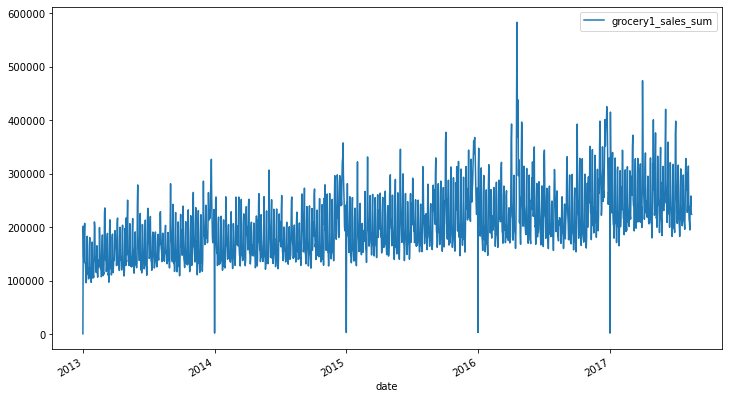

In [14]:
df_train_grocery1.plot(figsize=(12,7))

In [15]:
df_train_grocery1[df_train_grocery1['grocery1_sales_sum']==df_train_grocery1['grocery1_sales_sum'].max()]

,grocery1_sales_sum
date,
2016-04-18,583222.48


<AxesSubplot:xlabel='date'>

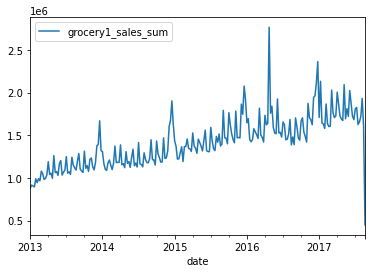

In [16]:
df_train_grocery1.resample('W').sum().plot()

In [17]:
#df_train_grocery1とholidayをマージ
df=df_train_grocery1.reset_index()
df_train_grocery=pd.merge(df, holiday, on='date', how='left')
df_train_grocery.duplicated().value_counts()
#ok!
df_train_grocery

,date,grocery1_sales_sum,type
0,2013-01-01,700.000,Holiday
1,2013-01-02,202020.000,NaN
2,2013-01-03,144878.000,NaN
3,2013-01-04,135754.000,NaN
4,2013-01-05,188356.000,NaN
...,...,...,...
1679,2017-08-11,238221.922,NaN
1680,2017-08-12,238627.633,NaN
1681,2017-08-13,258442.452,NaN
1682,2017-08-14,225355.694,NaN


### holidayかどうかでsalesに違いはないみたい

In [18]:
u=df_train_grocery.query('type=="Holiday"')['grocery1_sales_sum'].describe()
w=df_train_grocery.query('type!="Holiday"')['grocery1_sales_sum'].describe()
w,u

(count      1529.000000
 mean     203698.271560
 std       60396.761889
 min       96200.000000
 25%      157121.936000
 50%      193999.069000
 75%      239430.000000
 max      583222.480000
 Name: grocery1_sales_sum, dtype: float64,
 count       155.000000
 mean     206503.726903
 std       74716.995641
 min         700.000000
 25%      163167.262000
 50%      199989.000000
 75%      241883.898000
 max      474003.906000
 Name: grocery1_sales_sum, dtype: float64)

In [19]:
1529+155

1684

In [368]:
#df_train.query('family == "GROCERY I"').groupby('store_nbr').agg({'sales':'sum'})

In [369]:
#df_train.query('family=="GROCERY I" & store_nbr ==1') 

In [20]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


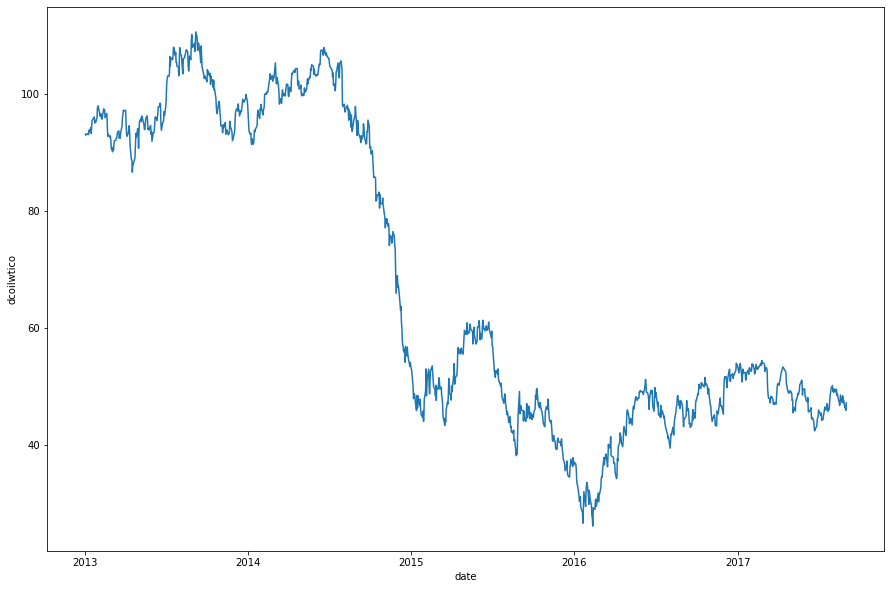

In [21]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='dcoilwtico', data=df_oil)
plt.show()

In [22]:
df_train.query('date=="2013-01-06"')['sales'].mean()

291.6360275465768

<AxesSubplot:xlabel='date'>

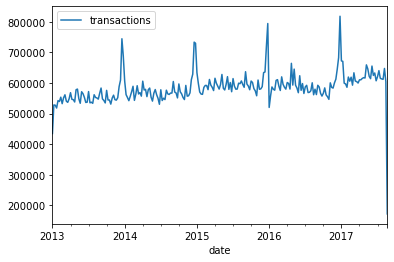

In [23]:
df_trans.groupby('date').agg({'transactions':'sum'}).resample('W').sum().plot()

In [24]:
#tranは使わなくてもいいかも
df_trans.groupby('date').agg({'transactions':'sum'})

,transactions
date,
2013-01-01,770
2013-01-02,93215
2013-01-03,78504
2013-01-04,78494
2013-01-05,93573
...,...
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993


In [25]:
df_holidays['description'].unique()

array(['Fundacion de Manta', 'Provincializacion de Cotopaxi',
       'Fundacion de Cuenca', 'Cantonizacion de Libertad',
       'Cantonizacion de Riobamba', 'Cantonizacion del Puyo',
       'Cantonizacion de Guaranda', 'Provincializacion de Imbabura',
       'Cantonizacion de Latacunga', 'Fundacion de Machala',
       'Fundacion de Santo Domingo', 'Cantonizacion de El Carmen',
       'Cantonizacion de Cayambe', 'Fundacion de Esmeraldas',
       'Primer Grito de Independencia', 'Fundacion de Riobamba',
       'Fundacion de Ambato', 'Fundacion de Ibarra',
       'Cantonizacion de Quevedo', 'Independencia de Guayaquil',
       'Traslado Independencia de Guayaquil', 'Dia de Difuntos',
       'Independencia de Cuenca', 'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia de Guaranda',
       'Independencia de Latacunga', 'Independencia de Ambato',
       'Fundacion de Quito-1', 'Fundacion de Quito', 'Fundacion de Loja',
       'Navidad-4', 'Cantonizac

In [26]:
df_holidays.query('description.str.contains("Terremoto Manabi")', engine='python')
#.query('name.str.contains("Mrs")', engine='python')

,date,type,locale,locale_name,description,transferred
219,2016-04-16,Event,National,Ecuador,Terremoto Manabi,False
220,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False
221,2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False
222,2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False
223,2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False
225,2016-04-21,Event,National,Ecuador,Terremoto Manabi+5,False
226,2016-04-22,Event,National,Ecuador,Terremoto Manabi+6,False
227,2016-04-23,Event,National,Ecuador,Terremoto Manabi+7,False
228,2016-04-24,Event,National,Ecuador,Terremoto Manabi+8,False
229,2016-04-25,Event,National,Ecuador,Terremoto Manabi+9,False


In [27]:
eq=df_holidays.query('description.str.contains("Terremoto Manabi")', engine='python')
eq=eq[['date','description']]
eq

,date,description
219,2016-04-16,Terremoto Manabi
220,2016-04-17,Terremoto Manabi+1
221,2016-04-18,Terremoto Manabi+2
222,2016-04-19,Terremoto Manabi+3
223,2016-04-20,Terremoto Manabi+4
225,2016-04-21,Terremoto Manabi+5
226,2016-04-22,Terremoto Manabi+6
227,2016-04-23,Terremoto Manabi+7
228,2016-04-24,Terremoto Manabi+8
229,2016-04-25,Terremoto Manabi+9


In [28]:
f=pd.merge(df, eq, on='date', how='left')
f

,date,grocery1_sales_sum,description
0,2013-01-01,700.000,NaN
1,2013-01-02,202020.000,NaN
2,2013-01-03,144878.000,NaN
3,2013-01-04,135754.000,NaN
4,2013-01-05,188356.000,NaN
...,...,...,...
1679,2017-08-11,238221.922,NaN
1680,2017-08-12,238627.633,NaN
1681,2017-08-13,258442.452,NaN
1682,2017-08-14,225355.694,NaN


In [29]:
df_train.groupby('family').sum()

,id,store_nbr,sales,onpromotion
family,,,,
AUTOMOTIVE,136442875140,2500740,5.548220e+05,4783
BABY CARE,136442966076,2500740,1.005100e+04,53
BEAUTY,136443057012,2500740,3.378930e+05,13483
BEVERAGES,136443147948,2500740,2.169545e+08,906958
BOOKS,136443238884,2500740,6.438000e+03,0
BREAD/BAKERY,136443329820,2500740,4.213395e+07,331289
CELEBRATION,136443420756,2500740,7.611770e+05,6723
CLEANING,136443511692,2500740,9.752129e+07,661157
DAIRY,136443602628,2500740,6.448771e+07,728707


In [30]:
df_train_grocery1_2=df_train.query('family == "GROCERY I"').groupby('date').sum()
df_train_grocery1_2=df_train_grocery1_2.drop(['id','store_nbr'], axis=1)
df_train_grocery1_2=df_train_grocery1_2.reset_index().drop('sales', axis=1)
df_train_grocery1_2

,date,onpromotion
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0
...,...,...
1679,2017-08-11,2349
1680,2017-08-12,2325
1681,2017-08-13,2320
1682,2017-08-14,2335


<AxesSubplot:ylabel='onpromotion'>

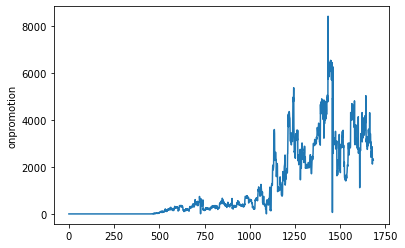

In [31]:
sns.lineplot(x=df_train_grocery1_2.index, y='onpromotion', data=df_train_grocery1_2)

In [32]:
df_train_grocery1_2.corr()

,onpromotion
onpromotion,1.0


### 相関係数0.5あるが見せかけの回帰に気を付けること

In [33]:
df_train_grocery1_true=pd.merge(f, df_train_grocery1_2, on='date', how='left')
df_train_grocery1_true

,date,grocery1_sales_sum,description,onpromotion
0,2013-01-01,700.000,NaN,0
1,2013-01-02,202020.000,NaN,0
2,2013-01-03,144878.000,NaN,0
3,2013-01-04,135754.000,NaN,0
4,2013-01-05,188356.000,NaN,0
...,...,...,...,...
1679,2017-08-11,238221.922,NaN,2349
1680,2017-08-12,238627.633,NaN,2325
1681,2017-08-13,258442.452,NaN,2320
1682,2017-08-14,225355.694,NaN,2335


<AxesSubplot:xlabel='grocery1_sales_sum', ylabel='onpromotion'>

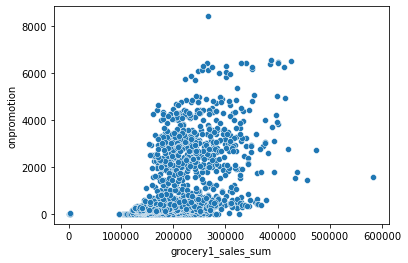

In [34]:
sns.scatterplot(x='grocery1_sales_sum', y='onpromotion', data=df_train_grocery1_true)

<AxesSubplot:xlabel='date'>

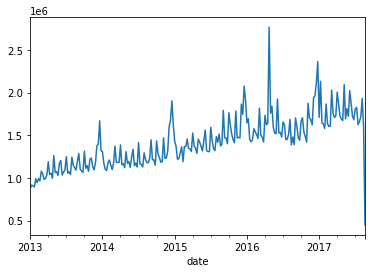

In [35]:
df_train_grocery1_true.set_index('date').resample('W').sum()['grocery1_sales_sum'].plot()

<AxesSubplot:xlabel='date'>

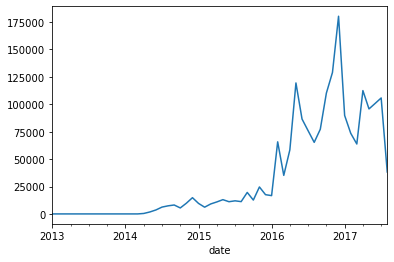

In [36]:
df_train_grocery1_true.set_index('date').resample('M').sum()['onpromotion'].plot()

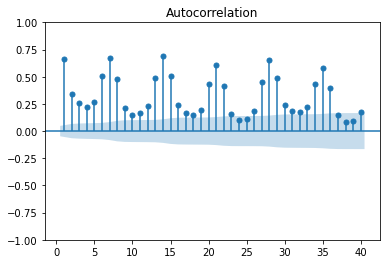

In [37]:
sgt.plot_acf(df_train_grocery1_true['grocery1_sales_sum'], lags=40, zero=False)
plt.show()

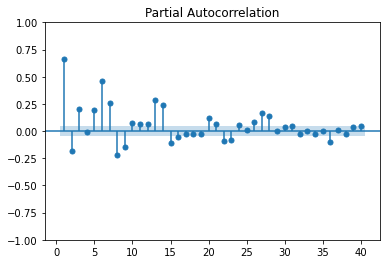

In [38]:
sgt.plot_pacf(df_train_grocery1_true['grocery1_sales_sum'], lags=40, zero=False, method=('ols'))
plt.show()

<AxesSubplot:xlabel='date'>

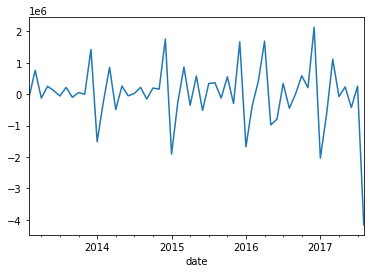

In [39]:
#差分をとってみる
df_train_grocery1_diff=df_train_grocery1_true.set_index('date').resample('M').sum()['grocery1_sales_sum'].diff(1).dropna()
df_train_grocery1_diff.plot()

In [40]:
df_train_grocery1_diff.reset_index()

,date,grocery1_sales_sum
0,2013-02-28,-112840.000
1,2013-03-31,760447.000
2,2013-04-30,-125833.000
3,2013-05-31,252085.000
4,2013-06-30,113573.000
5,2013-07-31,-57725.000
6,2013-08-31,215663.000
7,2013-09-30,-98016.000
8,2013-10-31,50784.000
9,2013-11-30,-3056.000


In [41]:
df_gor1_diff_2 = df_train_grocery1_diff.reset_index()
df_gor1_diff_2=df_gor1_diff_2.loc[0:53,'grocery1_sales_sum']
df_gor1_diff_2

0     -112840.000
1      760447.000
2     -125833.000
3      252085.000
4      113573.000
5      -57725.000
6      215663.000
7      -98016.000
8       50784.000
9       -3056.000
10    1424484.000
11   -1513530.463
12    -248098.537
13     856668.709
14    -490700.365
15     260206.874
16     -52940.501
17      22809.107
18     217020.492
19    -154976.964
20     196603.029
21     162666.834
22    1757920.930
23   -1907650.566
24    -273348.694
25     865437.060
26    -354491.216
27     578394.753
28    -518535.008
29     338997.828
30     363938.673
31    -125847.566
32     552745.849
33    -297482.647
34    1666794.744
35   -1675005.321
36    -376808.949
37     414999.103
38    1690948.945
39    -979548.136
40    -798011.193
41     339752.871
42    -447231.946
43       6145.283
44     587064.732
45     206160.894
46    2132078.289
47   -2035199.233
48    -645381.324
49    1113299.404
50     -74503.575
51     230734.563
52    -425965.020
53     255996.057
Name: grocery1_sales_sum, dt

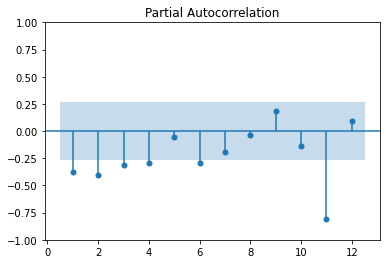

In [66]:
#差分に対して偏自己相関
sgt.plot_pacf(df_gor1_diff_2, lags=12, zero=False, method=('ols'))
plt.show()

In [43]:
stl=STL(df_train_grocery1_true['grocery1_sales_sum'], period=365, robust=True)
stl_series=stl.fit()

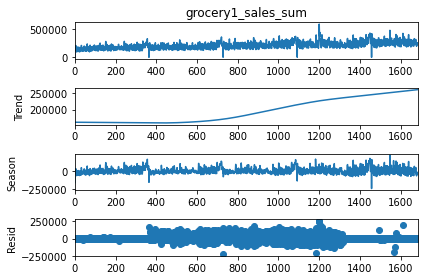

In [44]:
stl_series.plot()
plt.show()

In [45]:
stl2=STL(df_train_grocery1_diff, period=12, robust=True)
stl2_series=stl2.fit()

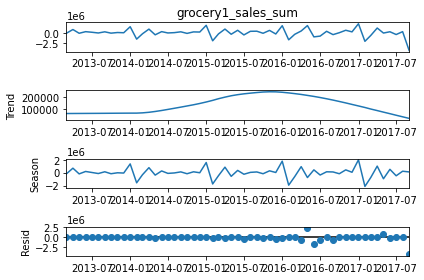

In [46]:
stl2_series.plot()
plt.show()

In [47]:
df_train_grocery1_true

,date,grocery1_sales_sum,description,onpromotion
0,2013-01-01,700.000,NaN,0
1,2013-01-02,202020.000,NaN,0
2,2013-01-03,144878.000,NaN,0
3,2013-01-04,135754.000,NaN,0
4,2013-01-05,188356.000,NaN,0
...,...,...,...,...
1679,2017-08-11,238221.922,NaN,2349
1680,2017-08-12,238627.633,NaN,2325
1681,2017-08-13,258442.452,NaN,2320
1682,2017-08-14,225355.694,NaN,2335


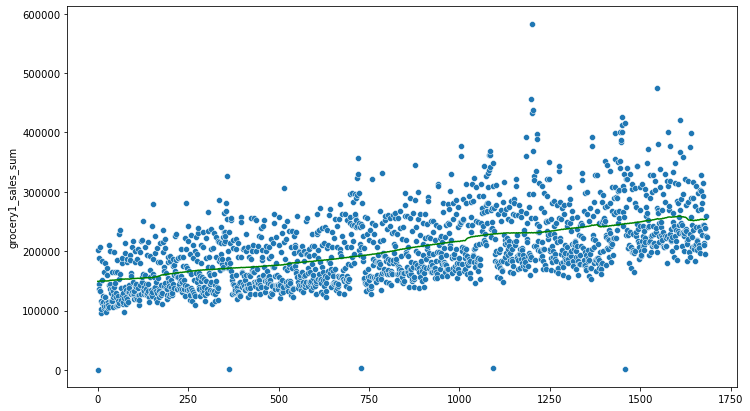

In [48]:
#365日移動平均線
moving_avg_gro = df_train_grocery1_true['grocery1_sales_sum'].rolling(window=365, center=True, min_periods=182).mean()
fig, ax=plt.subplots(figsize=(12,7))
sns.scatterplot(x=df_train_grocery1_true.index, y='grocery1_sales_sum', data=df_train_grocery1_true, ax=ax)
moving_avg_gro.plot(ax=ax, color='g')
plt.show()

In [49]:
#M
df_gro1_M=df_train_grocery1_true.set_index('date').resample('M').sum()
df_gro1_M=df_gro1_M.reset_index()
df_gro1_M

,date,grocery1_sales_sum,onpromotion
0,2013-01-31,4032240.000,0
1,2013-02-28,3919400.000,0
2,2013-03-31,4679847.000,0
3,2013-04-30,4554014.000,0
4,2013-05-31,4806099.000,0
5,2013-06-30,4919672.000,0
6,2013-07-31,4861947.000,0
7,2013-08-31,5077610.000,0
8,2013-09-30,4979594.000,0
9,2013-10-31,5030378.000,0


In [50]:
ma_gro_M2=df_gro1_M.rolling(window=12, center=True, min_periods=6).mean()
ma_gro_M2

,grocery1_sales_sum,onpromotion
0,4.485212e+06,0.000000
1,4.539031e+06,0.000000
2,4.606354e+06,0.000000
3,4.647825e+06,0.000000
4,4.686080e+06,0.000000
5,4.717102e+06,0.000000
6,4.861661e+06,0.000000
7,4.937164e+06,0.000000
8,5.001395e+06,0.000000
9,5.073645e+06,0.000000


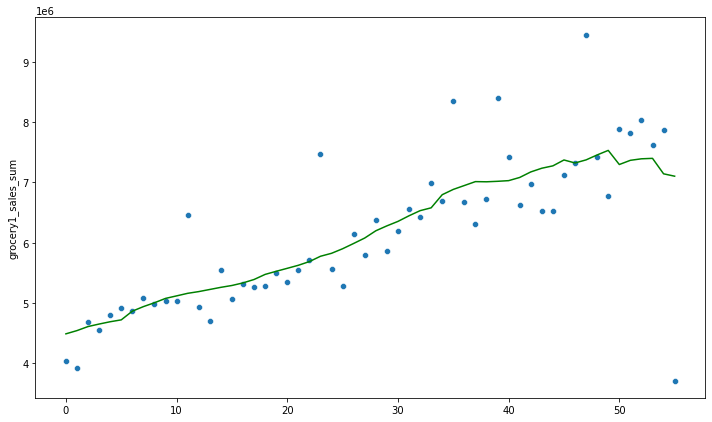

In [51]:
fig, ax=plt.subplots(figsize=(12,7))
sns.scatterplot(x=df_gro1_M.index ,y='grocery1_sales_sum', data=df_gro1_M ,ax=ax)
ma_gro_M2['grocery1_sales_sum'].plot(ax=ax,color='g')
plt.show()

In [52]:
#季節性

X=df_train_grocery1_true.copy()
X=X.set_index('date')
X['dayofweek']=X.index.dayofweek
X['week']=X.index.week
X['dayofyear']=X.index.dayofyear
X['year']=X.index.year
X

C:\Users\macch\AppData\Local\Temp/ipykernel_1036/2069105031.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X['week']=X.index.week


,grocery1_sales_sum,description,onpromotion,dayofweek,week,dayofyear,year
date,,,,,,,
2013-01-01,700.000,NaN,0,1,1,1,2013
2013-01-02,202020.000,NaN,0,2,1,2,2013
2013-01-03,144878.000,NaN,0,3,1,3,2013
2013-01-04,135754.000,NaN,0,4,1,4,2013
2013-01-05,188356.000,NaN,0,5,1,5,2013
...,...,...,...,...,...,...,...
2017-08-11,238221.922,NaN,2349,4,32,223,2017
2017-08-12,238627.633,NaN,2325,5,32,224,2017
2017-08-13,258442.452,NaN,2320,6,32,225,2017


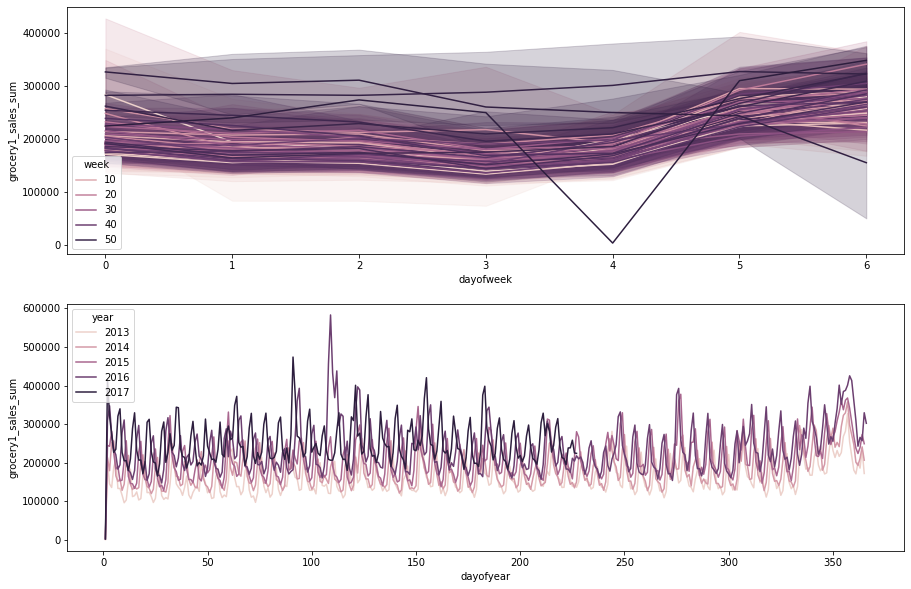

In [53]:
fig, (ax0,ax1)=plt.subplots(2,1, figsize=(15,10))
sns.lineplot(x='dayofweek', y='grocery1_sales_sum', ax=ax0, hue='week', data=X)
sns.lineplot(x='dayofyear', y='grocery1_sales_sum', ax=ax1, hue='year', data=X)
plt.show()

In [54]:
gro_season=df_gro1_M.copy().set_index('date')
gro_season['month']=gro_season.index.month
gro_season['year']=gro_season.index.year
gro_season

,grocery1_sales_sum,onpromotion,month,year
date,,,,
2013-01-31,4032240.000,0,1,2013
2013-02-28,3919400.000,0,2,2013
2013-03-31,4679847.000,0,3,2013
2013-04-30,4554014.000,0,4,2013
2013-05-31,4806099.000,0,5,2013
2013-06-30,4919672.000,0,6,2013
2013-07-31,4861947.000,0,7,2013
2013-08-31,5077610.000,0,8,2013
2013-09-30,4979594.000,0,9,2013


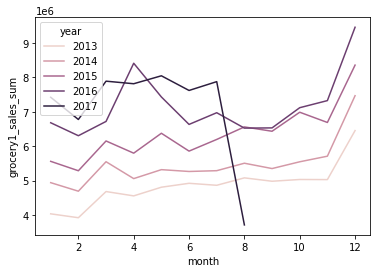

In [55]:
sns.lineplot(x='month', y='grocery1_sales_sum', hue='year', data=gro_season)
plt.show()

### 例年2月に下落、３月にちょい上げ、12月に急上昇

In [59]:
print('d =', arima.ndiffs(df_gro1_M['grocery1_sales_sum'])) #d（階差）
print('D =', arima.nsdiffs(df_gro1_M['grocery1_sales_sum'],m=12)) #D（季節階差）

d = 1
D = 1


In [62]:
data_d1_d12 = pd.DataFrame(df_gro1_M['grocery1_sales_sum']).diff(1).diff(12).dropna()
data_d1_d12

,grocery1_sales_sum
13,-135258.537
14,96221.709
15,-364867.365
16,8121.874
17,-166513.501
18,80534.107
19,1357.492
20,-56960.964
21,145819.029
22,165722.834


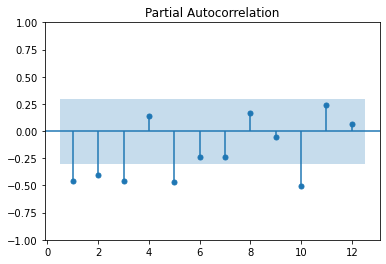

In [65]:
sgt.plot_pacf(data_d1_d12, lags=12, zero=False, method=('ols'))
plt.show()

In [69]:
arima_model = pm.auto_arima(df_gro1_M['grocery1_sales_sum'], 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

C:\Users\macch\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1325.485, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1313.477, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1317.245, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1317.250, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1341.005, Time=0.00 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1315.395, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1315.371, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1317.351, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1315.264, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1315.333, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1317.208, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.518 seconds


日にちでsalesを合計：週や月も後でまとめてみたい

In [11]:
df_sum=df_train.groupby('date').agg({'sales':'sum'}).reset_index()
df_sum.head(7)

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
5,2013-01-06,519695.401088
6,2013-01-07,336122.801066


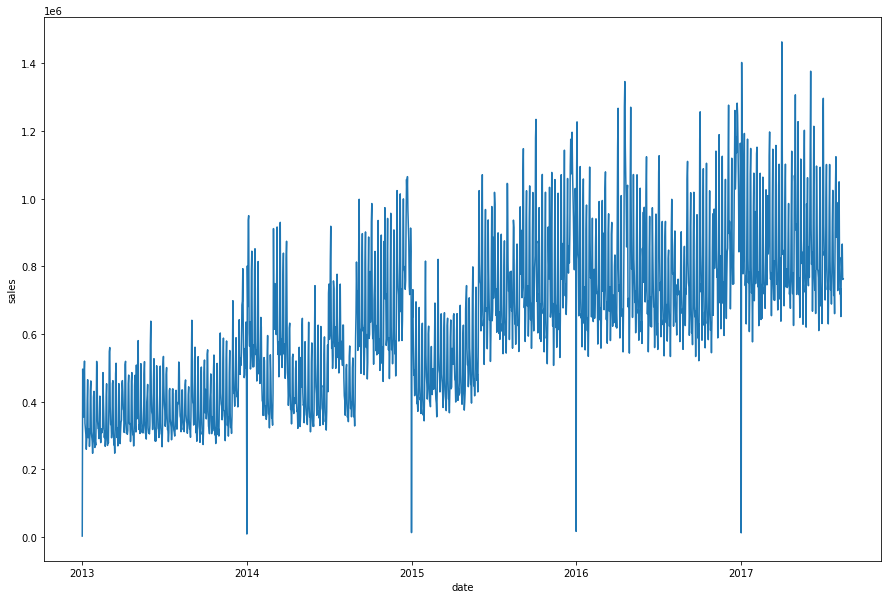

In [12]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='sales', data=df_sum)
plt.show()

In [13]:
#タイムダミーを作成
df_sum['time']= np.arange(len(df_sum.index))
df_sum

,date,sales,time
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,1
2,2013-01-03,361461.231124,2
3,2013-01-04,354459.677093,3
4,2013-01-05,477350.121229,4
...,...,...,...
1679,2017-08-11,826373.722022,1679
1680,2017-08-12,792630.535079,1680
1681,2017-08-13,865639.677471,1681
1682,2017-08-14,760922.406081,1682


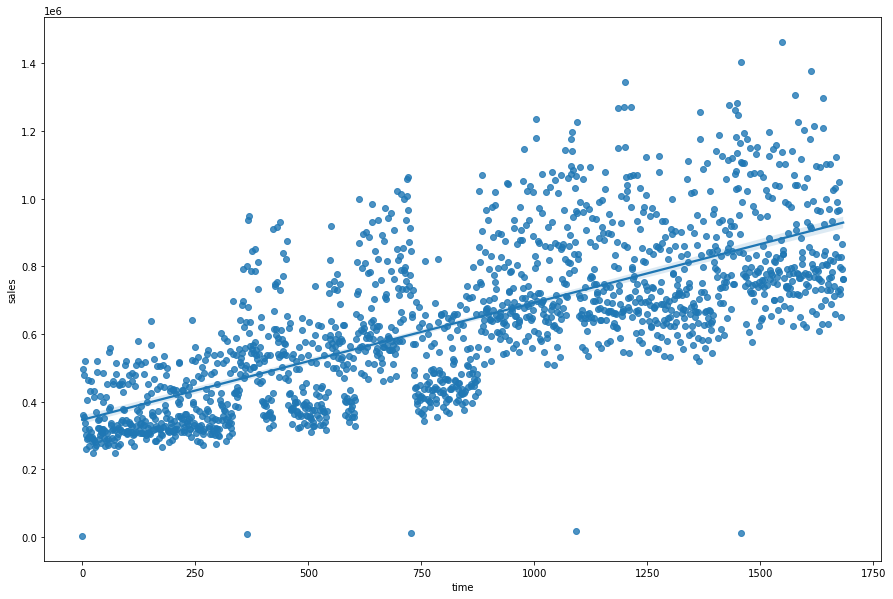

In [14]:
plt.figure(figsize=(15,10))
sns.regplot(x='time', y='sales', data=df_sum)
plt.show()

In [15]:
#タイムダミーを特徴量にsalesを目的変数として線形回帰
#Xはloc[:,['time']]
#yはloc[:,'sales']にしないとこのセルは実行されない
X=df_sum.loc[:,['time']]
y=df_sum.loc[:,'sales']

LR=LinearRegression()
LR.fit(X,y)
print(LR.intercept_,LR.coef_)
y_pred=pd.Series(LR.predict(X), index=X.index)
y_pred

346122.8320909401 [346.32626599]


0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

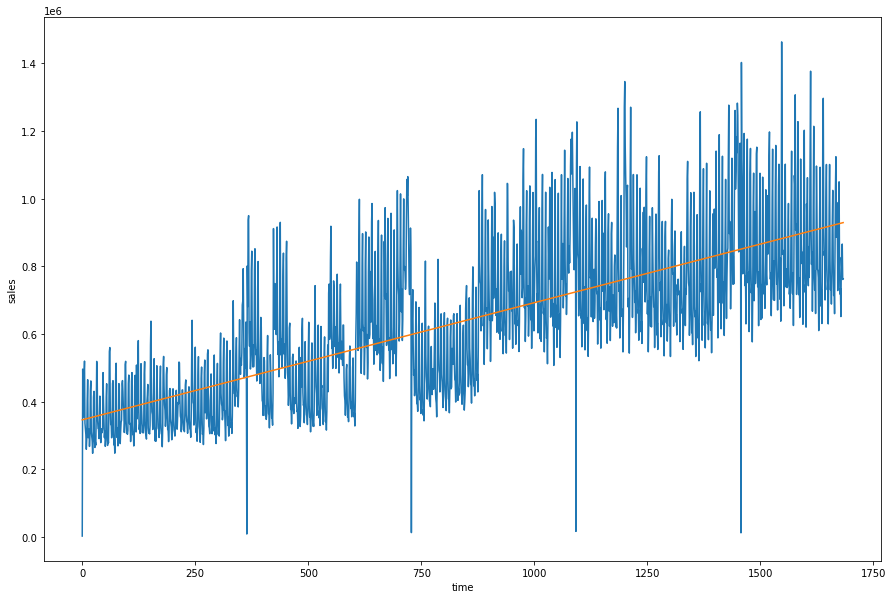

In [16]:
#もとの時系列データを回帰直線をプロット
plt.figure(figsize=(15,10))
sns.lineplot(x='time', y='sales', data=df_sum)
y_pred.plot()
plt.show()

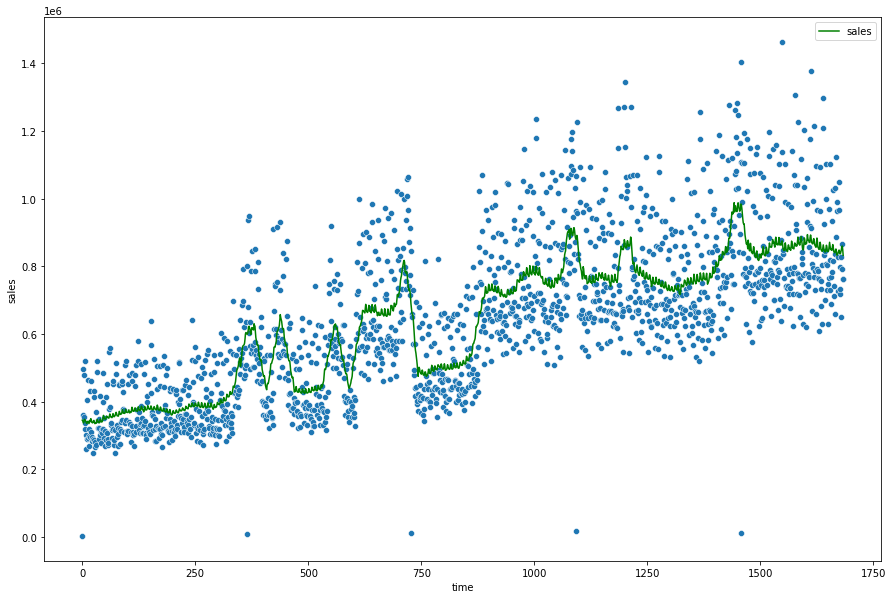

0       345177.747714
1       343500.883104
2       339030.155626
3       336646.860870
4       341689.649878
            ...      
1679    848509.631730
1680    858439.095134
1681    859735.729185
1682    849584.250565
1683    832448.736353
Name: sales, Length: 1684, dtype: float64

In [17]:
#30日移動平均線⇒右上がりなのが分かる⇒一次式で近似、予測？
moving_avg = df_sum['sales'].rolling(window=30, center=True, min_periods=15).mean()
fig, ax=plt.subplots(figsize=(15,10))
ax=sns.scatterplot(x='time', y='sales', data=df_sum)
moving_avg.plot(color='g', ax=ax)
plt.legend()
plt.show()
display(moving_avg)

In [18]:
#DeterministicProcessを使ってトレンドを線形回帰で予測（さっきやったけど）
#タイムダミー特徴量作成
from statsmodels.tsa.deterministic import DeterministicProcess

dp=DeterministicProcess(index=df_sum.index, constant=True, order=1, drop=True)
X=dp.in_sample()
X

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
1679,1.0,1680.0
1680,1.0,1681.0
1681,1.0,1682.0
1682,1.0,1683.0


In [19]:
from sklearn.linear_model import LinearRegression
model=LinearRegression(fit_intercept=False)
y=df_sum['sales']
model.fit(X,y)

LinearRegression(fit_intercept=False)

In [20]:
#indexを'date'にしておくのかなり重要（あとでこっちのほうが良いと感じる）
#上の作業は絶対にしてはいけない
y_pred1=pd.Series(model.predict(X), index=y.index)
y_pred1

0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

In [21]:
df_sum

,date,sales,time
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,1
2,2013-01-03,361461.231124,2
3,2013-01-04,354459.677093,3
4,2013-01-05,477350.121229,4
...,...,...,...
1679,2017-08-11,826373.722022,1679
1680,2017-08-12,792630.535079,1680
1681,2017-08-13,865639.677471,1681
1682,2017-08-14,760922.406081,1682


## 30日後の予測を行う

In [22]:
#30日先のデータ作成
X = dp.out_of_sample(steps=30)
#30日先を予測
y_fore = pd.Series(model.predict(X), index=X.index)
X['forecast'] = y_fore
display(X)

,const,trend,forecast
1684,1.0,1685.0,929336.264012
1685,1.0,1686.0,929682.590278
1686,1.0,1687.0,930028.916544
1687,1.0,1688.0,930375.242810
1688,1.0,1689.0,930721.569076
1689,1.0,1690.0,931067.895342
1690,1.0,1691.0,931414.221608
1691,1.0,1692.0,931760.547874
1692,1.0,1693.0,932106.874140
1693,1.0,1694.0,932453.200406


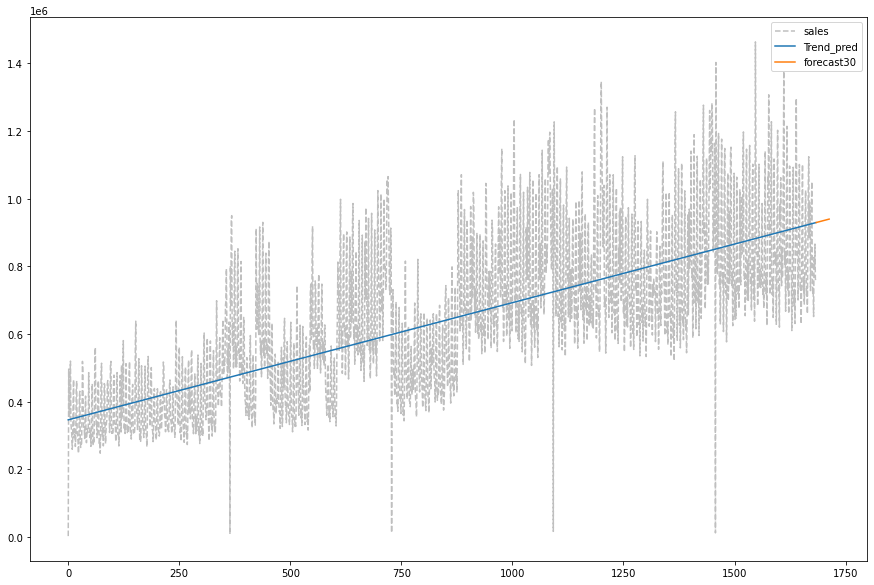

In [23]:
#30日後を予測したグラフ
fig, ax=plt.subplots(figsize=(15,10))
df_sum.plot(y='sales',linestyle='dashed',color="0.75",ax=ax)
y_pred1.plot(label="Trend_pred",ax=ax)
y_fore.plot(ax=ax, label='forecast30')
plt.legend()

## 季節性

In [24]:
#df_sumを新しいXに格納
X=df_sum.copy()
X=X.set_index('date')
#'time'いらないからなくす
X=X.drop('time', axis=1)
display(X)
X['dayofweek']= X.index.dayofweek
X['week'] = X.index.week
X['dayofyear']=X.index.dayofyear
X['year']=X.index.year
X

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


C:\Users\macch\AppData\Local\Temp/ipykernel_5540/1133008777.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X['week'] = X.index.week


,sales,dayofweek,week,dayofyear,year
date,,,,,
2013-01-01,2511.618999,1,1,1,2013
2013-01-02,496092.417944,2,1,2,2013
2013-01-03,361461.231124,3,1,3,2013
2013-01-04,354459.677093,4,1,4,2013
2013-01-05,477350.121229,5,1,5,2013
...,...,...,...,...,...
2017-08-11,826373.722022,4,32,223,2017
2017-08-12,792630.535079,5,32,224,2017
2017-08-13,865639.677471,6,32,225,2017


### 季節性プロットをする

Text(0.5, 1.0, 'seasonalplot (year/dayofyear)')

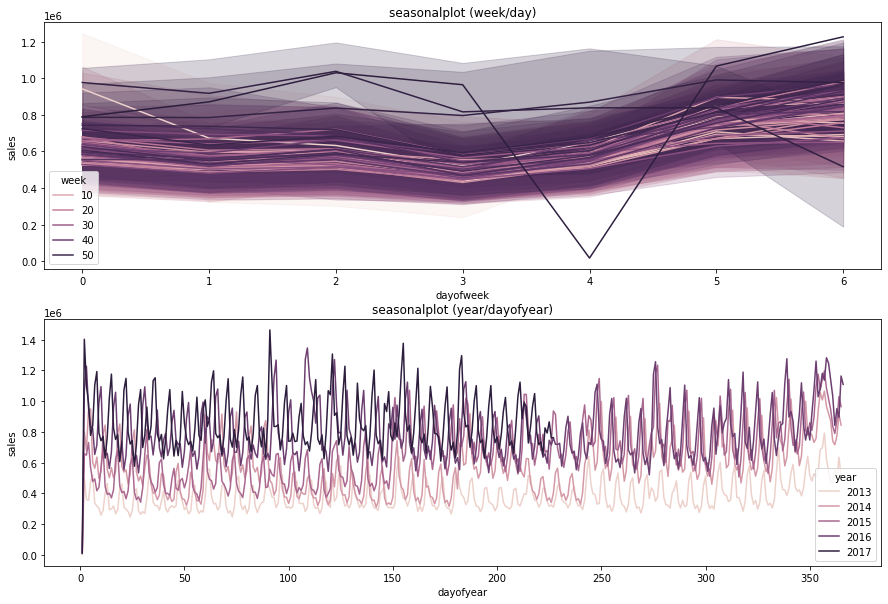

In [25]:
fig, (ax0,ax1)=plt.subplots(2,1,figsize=(15,10))
sns.lineplot(x='dayofweek',y='sales', data=X, ax=ax0, hue='week' )
ax0.set_title('seasonalplot (week/day)')
sns.lineplot(x='dayofyear', y='sales', data=X, ax=ax1, hue='year')
ax1.set_title('seasonalplot (year/dayofyear)')

## ピリオドグラムをプロット

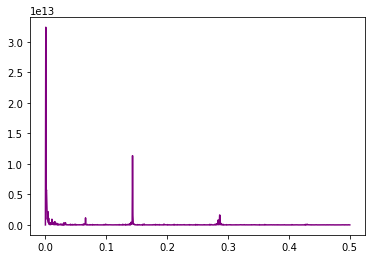

In [26]:
from scipy.signal import periodogram

#fs = pd.Timedelta("365D") / pd.Timedelta("1D")
f, spec = periodogram(X['sales'])
plt.plot(f, spec, color="purple")


In [27]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

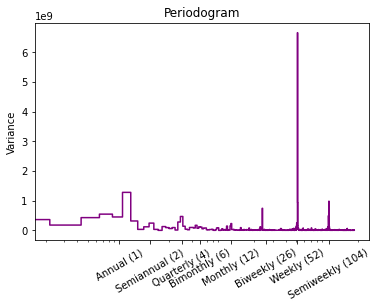

In [28]:
plot_periodogram(ts=X['sales'])

## 季節性をモデル化して予測しよう

In [29]:
#DeterministicProcess(index=df_sum,は１次元配列でないとダメなので作り直し
#もう一度df_sumを作り直し
df_sum=df_train.groupby('date').agg({'sales':'sum'})
#ここで必ず.to_period('Dを加えて変換すること！！')そうしないとDeterministicProcessが受け付けない
df_sum=df_sum.to_period('D')
df_sum.head(7)

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
2013-01-06,519695.401088
2013-01-07,336122.801066


In [30]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   1684 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [31]:
#特徴量作成
from statsmodels.tsa.deterministic import CalendarFourier
# 10 sin/cos pairs for "A"nnual seasonality
fourier = CalendarFourier(freq='A', order=10)

dp=DeterministicProcess(index=df_sum.index, constant=True,  order=1, seasonal=True, additional_terms=[fourier], drop=True)

### 特徴量作成と線形回帰での予測（季節性）

In [32]:
# create features for dates in tunnel.index
X=dp.in_sample()
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,...,-0.806480,-0.591261,0.998880,-0.047321,-0.746972,0.664855,0.162807,-0.986658,0.493776,0.869589
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,...,-0.863142,-0.504961,0.985948,-0.167052,-0.648630,0.761104,0.008607,-0.999963,0.635432,0.772157
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,...,-0.910605,-0.413279,0.958718,-0.284359,-0.538005,0.842942,-0.145799,-0.989314,0.758306,0.651899


In [33]:
y=df_sum['sales']
display(y)
#このモデルはXGBoostとかでもいいかもと思ったけどそれはこの先でやる
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
y_pred2=pd.Series(model.predict(X), index=y.index)

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1684, dtype: float64

### 90日後の予測値を作成

In [34]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_fore

2017-08-16    8.985779e+05
2017-08-17    8.464121e+05
2017-08-18    8.086022e+05
2017-08-19    8.346422e+05
2017-08-20    8.997903e+05
                  ...     
2017-11-09    9.580241e+05
2017-11-10    9.170420e+05
2017-11-11    9.389605e+05
2017-11-12    9.991162e+05
2017-11-13    1.028587e+06
Freq: D, Length: 90, dtype: float64

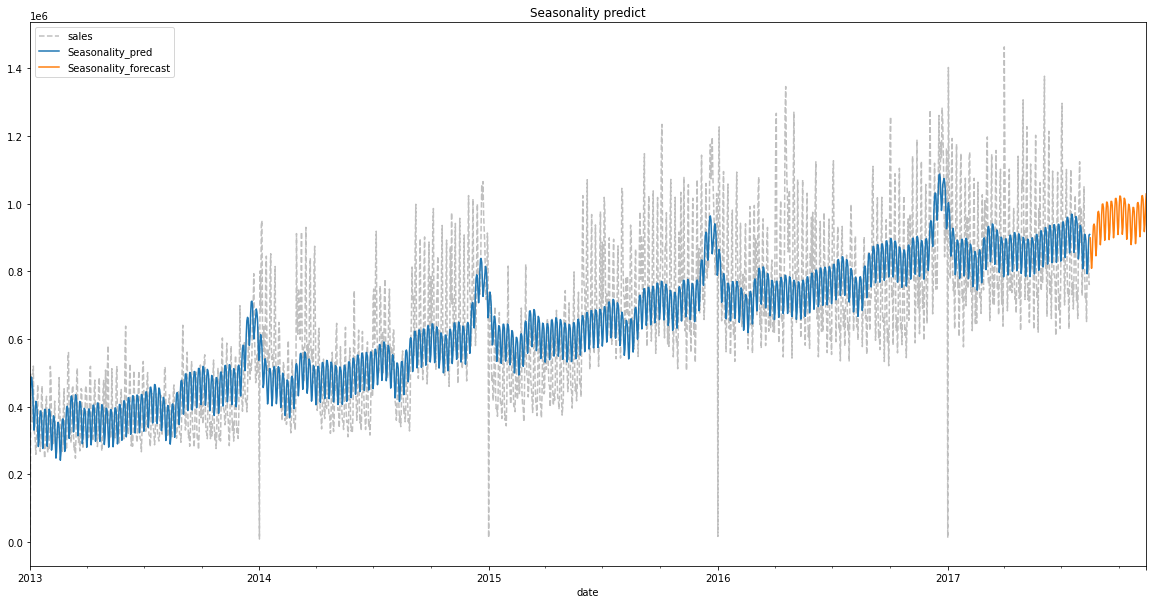

In [35]:
#90日分の予測値をプロット
fig, ax = plt.subplots(figsize=(20,10))
df_sum.plot(linestyle='dashed',color="0.75",ax=ax)
y_pred2.plot(ax=ax,label="Seasonality_pred")
y_fore.plot(ax=ax, label='Seasonality_zforecast')
ax.set_title('Seasonality predict')
plt.legend()

## 4. Time Series as Features

### ラグ特徴量がこのあたりから出てくる

In [36]:
y

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1684, dtype: float64

In [37]:
#まずは残差を求めよう！
y=df_sum['sales']

y=y.reset_index().drop('date', axis=1)
display(y)
y_pred1=pd.DataFrame(y_pred1, columns=['sales'])
y_pred1

,sales
0,2511.618999
1,496092.417944
2,361461.231124
3,354459.677093
4,477350.121229
...,...
1679,826373.722022
1680,792630.535079
1681,865639.677471
1682,760922.406081


,sales
0,346122.832091
1,346469.158357
2,346815.484623
3,347161.810889
4,347508.137155
...,...
1679,927604.632682
1680,927950.958948
1681,928297.285214
1682,928643.611480


In [38]:
#残差
y_deseason=y - y_pred1
y_deseason

,sales
0,-343611.213092
1,149623.259587
2,14645.746501
3,7297.866204
4,129841.984074
...,...
1679,-101230.910660
1680,-135320.423870
1681,-62657.607743
1682,-167721.205400


<AxesSubplot:>

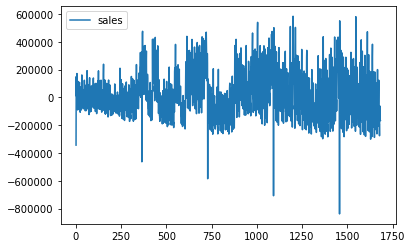

In [39]:
y_deseason.plot()

In [40]:
y_delag=y_deseason.copy()
y_delag['lag1'] = y_deseason.shift(1)
y_delag['lag8'] = y_deseason['sales'].shift(8)
y_delag['lag10']= y_deseason['sales'].shift(10)

In [41]:
y_delag

,sales,lag1,lag8,lag10
0,-343611.213092,NaN,NaN,NaN
1,149623.259587,-343611.213092,NaN,NaN
2,14645.746501,149623.259587,NaN,NaN
3,7297.866204,14645.746501,NaN,NaN
4,129841.984074,7297.866204,NaN,NaN
...,...,...,...,...
1679,-101230.910660,-275871.394447,-196765.537423,64386.393181
1680,-135320.423870,-101230.910660,-97404.662693,40224.319762
1681,-62657.607743,-135320.423870,40166.975405,-196765.537423
1682,-167721.205400,-62657.607743,123686.162924,-97404.662693


,sales,lag1,lag8,lag10
sales,1.000000,0.518507,0.339005,-0.073387
lag1,0.518507,1.000000,0.640981,-0.021224
lag8,0.339005,0.640981,1.000000,0.096504
lag10,-0.073387,-0.021224,0.096504,1.000000


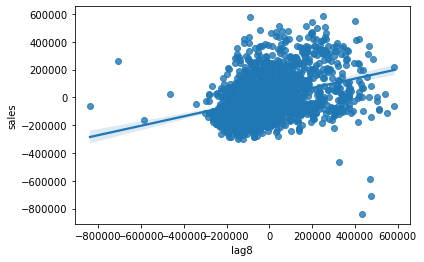

In [42]:
#ラグプロット
sns.regplot(x='lag8', y='sales', data=y_delag)
y_delag.corr()

In [43]:
y_deseason.shape

(1684, 1)

C:\Users\macch\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


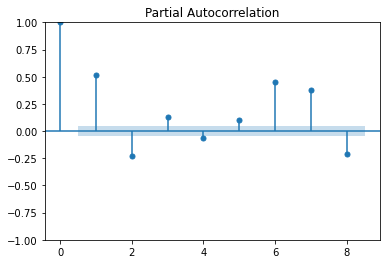

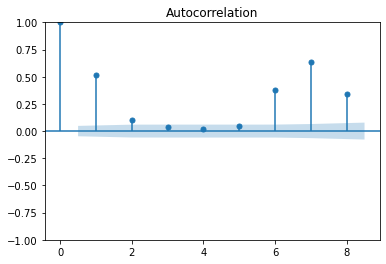

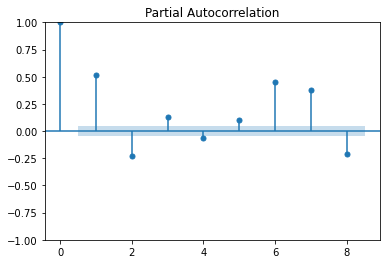

In [44]:
#自己相関と偏自己相関
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(y_deseason, lags=8)
sm.graphics.tsa.plot_pacf(y_deseason, lags=8)

In [45]:
#特徴量作成ののち予測
#1～4までを特徴量に
def make_lags(ts, lags):
    return pd.concat({
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1) }, axis=1)

X=make_lags(df_sum, 4)
X=X.fillna(0.0)
#配列に変換
X=X.values
X

array([[     0.       ,      0.       ,      0.       ,      0.       ],
       [  2511.618999 ,      0.       ,      0.       ,      0.       ],
       [496092.417944 ,   2511.618999 ,      0.       ,      0.       ],
       ...,
       [792630.5350785, 826373.722022 , 651386.9119697, 734139.67401  ],
       [865639.677471 , 792630.5350785, 826373.722022 , 651386.9119697],
       [760922.4060808, 865639.677471 , 792630.5350785, 826373.722022 ]])

## fit and predict(ラグ特徴量に対して）

In [46]:
y

,sales
0,2511.618999
1,496092.417944
2,361461.231124
3,354459.677093
4,477350.121229
...,...
1679,826373.722022
1680,792630.535079
1681,865639.677471
1682,760922.406081


In [47]:
# Create target series and data splits
y=y_deseason.copy()
# Fit and predict
model2=LinearRegression(fit_intercept=False)
model2.fit(X,y)
y_pred=pd.DataFrame(model2.predict(X), index=y.index, columns=['sales'])
y_pred

,sales
0,0.000000
1,1330.933381
2,261852.966107
3,-11944.783811
4,94238.627678
...,...
1679,-50831.297426
1680,95170.668585
1681,-7416.571746
1682,82805.670261


In [48]:
df_sum=df_train.groupby('date').agg({'sales':'sum'}).reset_index()
df_sum

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [49]:
#y_deseasonのインデックスにdf_sumのdateを割り当てる（y_predと比較するグラフを作成するときに日付で比較したいため）
df_sum2 = df_sum.copy()
display(df_sum2)
y_deseason_copy = y_deseason.copy()
y_deseason_copy['date'] =df_sum2['date']
y_deseason_copy=y_deseason_copy.set_index('date')
y_deseason_copy

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


,sales
date,
2013-01-01,-343611.213092
2013-01-02,149623.259587
2013-01-03,14645.746501
2013-01-04,7297.866204
2013-01-05,129841.984074
...,...
2017-08-11,-101230.910660
2017-08-12,-135320.423870
2017-08-13,-62657.607743


In [50]:
#y_predのインデックスにdf_sumのdateを割り当てる
y_pred['date'] = df_sum['date']
y_pred = y_pred.set_index('date')
y_pred

,sales
date,
2013-01-01,0.000000
2013-01-02,1330.933381
2013-01-03,261852.966107
2013-01-04,-11944.783811
2013-01-05,94238.627678
...,...
2017-08-11,-50831.297426
2017-08-12,95170.668585
2017-08-13,-7416.571746


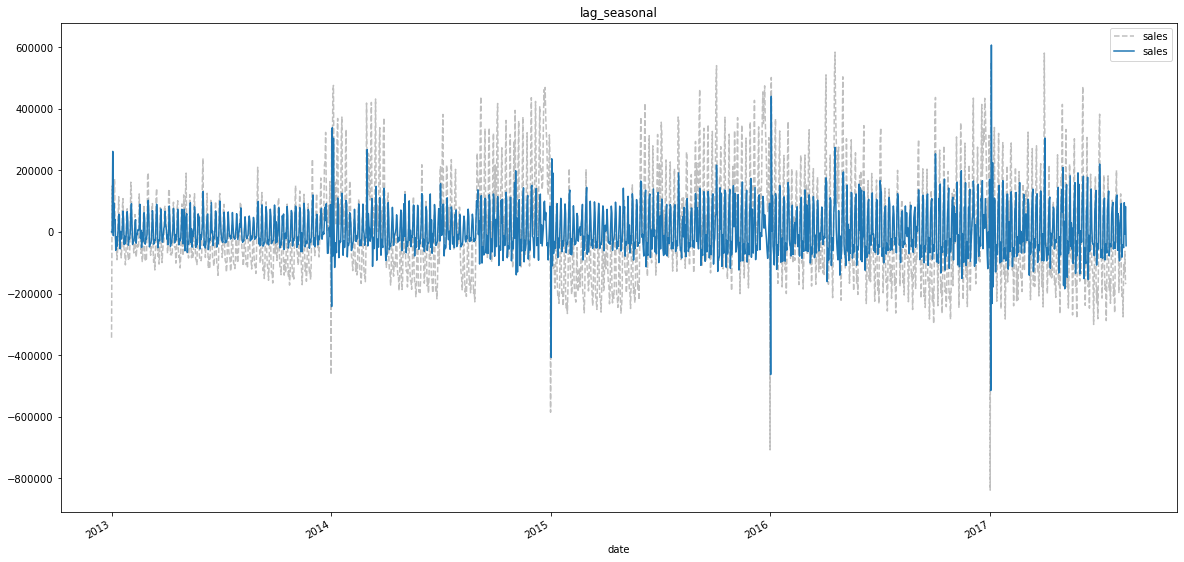

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
y_deseason_copy.plot(linestyle='dashed',color="0.75",ax=ax)
y_pred.plot(ax=ax,label="Seasonality_pred")
ax.set_title('lag_seasonal')
plt.legend()

<AxesSubplot:xlabel='date'>

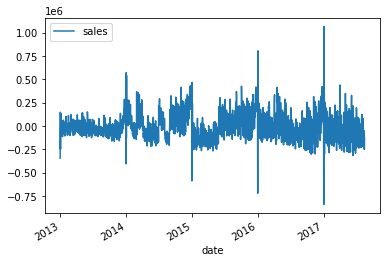

In [52]:
redi=y_deseason_copy - y_pred
redi.plot()

<AxesSubplot:xlabel='date'>

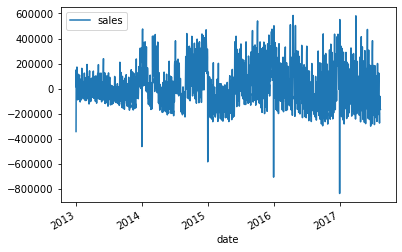

In [53]:
y_deseason_copy.plot()

<AxesSubplot:>

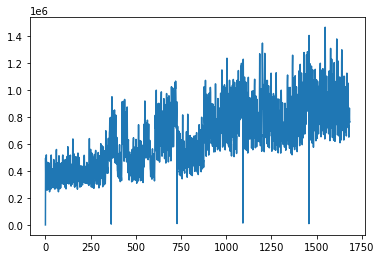

In [54]:
df_sum['sales'].plot()

# Hybrid Models

In [55]:
y_deseason_copy

,sales
date,
2013-01-01,-343611.213092
2013-01-02,149623.259587
2013-01-03,14645.746501
2013-01-04,7297.866204
2013-01-05,129841.984074
...,...
2017-08-11,-101230.910660
2017-08-12,-135320.423870
2017-08-13,-62657.607743


## 特徴量生成（XGB）

In [56]:
#トレンド予測
df_sum=df_train.groupby('date').agg({'sales':'sum'}).reset_index()
from statsmodels.tsa.deterministic import DeterministicProcess

dp=DeterministicProcess(index=df_sum.index, constant=True, order=1, drop=True)
X=dp.in_sample()

from sklearn.linear_model import LinearRegression
model=LinearRegression(fit_intercept=False)
y=df_sum['sales']
model.fit(X,y)

y_pred1=pd.Series(model.predict(X), index=y.index)
y_pred1

y_pred_1 = y_pred1.copy()
y_pred_1

0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

In [57]:
df_sum

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [58]:
df_sum['sales']

0         2511.618999
1       496092.417944
2       361461.231124
3       354459.677093
4       477350.121229
            ...      
1679    826373.722022
1680    792630.535079
1681    865639.677471
1682    760922.406081
1683    762661.935939
Name: sales, Length: 1684, dtype: float64

In [59]:
#目的変数作成
y_deseason_xgb = df_sum['sales'] - y_pred_1
display(y_deseason_xgb)
#indexをdateに
y_deseason_xgb.index = df_train.groupby('date').agg({'sales':'sum'}).index
display(y_deseason_xgb)

0      -343611.213092
1       149623.259587
2        14645.746501
3         7297.866204
4       129841.984074
            ...      
1679   -101230.910660
1680   -135320.423870
1681    -62657.607743
1682   -167721.205400
1683   -166328.001807
Length: 1684, dtype: float64

date
2013-01-01   -343611.213092
2013-01-02    149623.259587
2013-01-03     14645.746501
2013-01-04      7297.866204
2013-01-05    129841.984074
                  ...      
2017-08-11   -101230.910660
2017-08-12   -135320.423870
2017-08-13    -62657.607743
2017-08-14   -167721.205400
2017-08-15   -166328.001807
Length: 1684, dtype: float64

In [60]:
y_deseason_copy

,sales
date,
2013-01-01,-343611.213092
2013-01-02,149623.259587
2013-01-03,14645.746501
2013-01-04,7297.866204
2013-01-05,129841.984074
...,...
2017-08-11,-101230.910660
2017-08-12,-135320.423870
2017-08-13,-62657.607743


In [61]:
#XGB用の特徴量を作成
df_sum_pre = df_sum.set_index('date')
df_sum_pre['dayofyear'] = df_sum_pre.index.dayofyear
X_1=df_sum_pre
X_1

,sales,dayofyear
date,,
2013-01-01,2511.618999,1
2013-01-02,496092.417944,2
2013-01-03,361461.231124,3
2013-01-04,354459.677093,4
2013-01-05,477350.121229,5
...,...,...
2017-08-11,826373.722022,223
2017-08-12,792630.535079,224
2017-08-13,865639.677471,225


In [62]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_1, y_deseason_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [63]:
#予測値を算出（XGB）
y_pred_xgb = pd.Series(xgb.predict(X_1), index=X_1.index)
y_pred_xgb

date
2013-01-01   -344484.312500
2013-01-02    136594.406250
2013-01-03     15176.704102
2013-01-04      3279.194824
2013-01-05    112034.304688
                  ...      
2017-08-11    -61699.238281
2017-08-12   -105376.351562
2017-08-13    -13373.166992
2017-08-14   -112167.320312
2017-08-15   -105889.328125
Length: 1684, dtype: float32

<AxesSubplot:xlabel='date'>

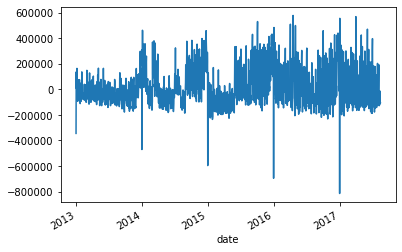

In [64]:
y_pred_xgb.plot()

## y_pred_1とy_pred_xgbを足す

In [65]:
#下で足しやすいようにindex=dateにする
y_pred_1.index=df_train.groupby('date').agg({'sales':'sum'}).index

In [66]:
#足す
y_pred_boosted = y_pred_xgb + y_pred_1
y_pred_boosted

date
2013-01-01      1638.519591
2013-01-02    483063.564607
2013-01-03    361992.188724
2013-01-04    350441.005713
2013-01-05    459542.441842
                  ...      
2017-08-11    865905.394401
2017-08-12    822574.607386
2017-08-13    914924.118222
2017-08-14    816476.291168
2017-08-15    823100.609621
Length: 1684, dtype: float64

<AxesSubplot:xlabel='date'>

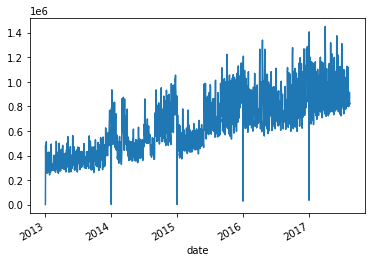

In [67]:
y_pred_boosted.plot()

In [68]:
#df_sumのindexをdate
df_sum_date = df_sum.copy().drop('date', axis=1)
df_sum_date.index = df_train.groupby('date').agg({'sales':'sum'}).index
df_sum_date

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


<AxesSubplot:xlabel='date'>

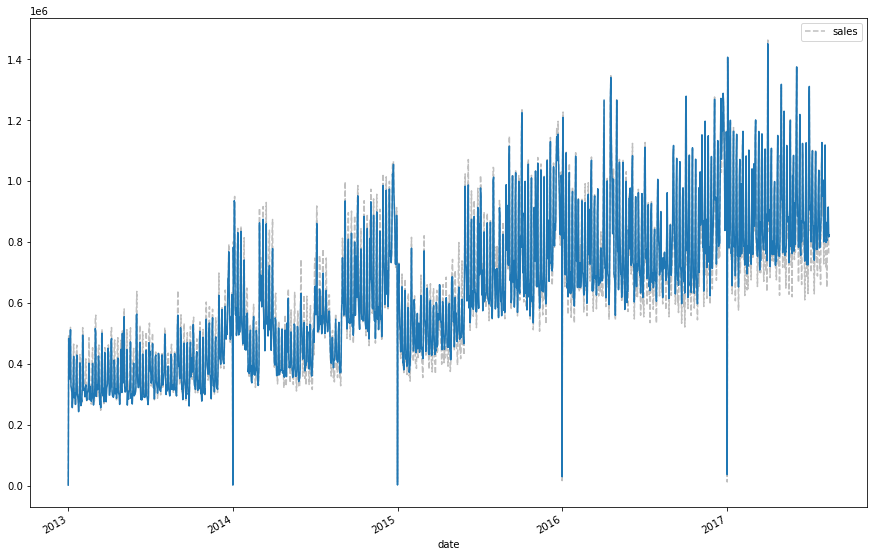

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
df_sum_date.plot(ax=ax,linestyle='dashed',color="0.75")
y_pred_boosted.plot(ax=ax)

# LightGBMでやってみた

In [74]:
#LightGBM
y_pred_2 = y_pred1.copy()
y_pred_2

0       346122.832091
1       346469.158357
2       346815.484623
3       347161.810889
4       347508.137155
            ...      
1679    927604.632682
1680    927950.958948
1681    928297.285214
1682    928643.611480
1683    928989.937746
Length: 1684, dtype: float64

In [78]:
#目的変数作成
y_deseason_gbm = df_sum['sales'] - y_pred_2
display(y_deseason_gbm)

0      -343611.213092
1       149623.259587
2        14645.746501
3         7297.866204
4       129841.984074
            ...      
1679   -101230.910660
1680   -135320.423870
1681    -62657.607743
1682   -167721.205400
1683   -166328.001807
Length: 1684, dtype: float64

In [79]:
#indexをdateに
y_deseason_gbm.index = df_train.groupby('date').agg({'sales':'sum'}).index
display(y_deseason_gbm)

date
2013-01-01   -343611.213092
2013-01-02    149623.259587
2013-01-03     14645.746501
2013-01-04      7297.866204
2013-01-05    129841.984074
                  ...      
2017-08-11   -101230.910660
2017-08-12   -135320.423870
2017-08-13    -62657.607743
2017-08-14   -167721.205400
2017-08-15   -166328.001807
Length: 1684, dtype: float64

In [80]:
#LightGBM用の特徴量を作成
df_sum_pre2 = df_sum.set_index('date')
df_sum_pre2['dayofyear'] = df_sum_pre2.index.dayofyear
X_1_gbm=df_sum_pre2
X_1_gbm

,sales,dayofyear
date,,
2013-01-01,2511.618999,1
2013-01-02,496092.417944,2
2013-01-03,361461.231124,3
2013-01-04,354459.677093,4
2013-01-05,477350.121229,5
...,...,...
2017-08-11,826373.722022,223
2017-08-12,792630.535079,224
2017-08-13,865639.677471,225


In [81]:
from lightgbm import LGBMRegressor
model_gbm = LGBMRegressor()
model_gbm.fit(X_1_gbm, y_deseason_gbm)

LGBMRegressor()

In [82]:
#予測値を算出（GBM）
y_pred_gbm = pd.Series(model_gbm.predict(X_1_gbm), index=X_1_gbm.index)
y_pred_gbm

date
2013-01-01   -419796.711416
2013-01-02     56110.066060
2013-01-03   -106075.503479
2013-01-04   -106075.503479
2013-01-05     58906.886713
                  ...      
2017-08-11    -66642.509489
2017-08-12    -34184.229543
2017-08-13     47962.098336
2017-08-14    -81112.962095
2017-08-15    -81112.962095
Length: 1684, dtype: float64

In [83]:
#下で足しやすいようにindex=dateにする
y_pred_2.index=df_train.groupby('date').agg({'sales':'sum'}).index
y_pred_2

date
2013-01-01    346122.832091
2013-01-02    346469.158357
2013-01-03    346815.484623
2013-01-04    347161.810889
2013-01-05    347508.137155
                  ...      
2017-08-11    927604.632682
2017-08-12    927950.958948
2017-08-13    928297.285214
2017-08-14    928643.611480
2017-08-15    928989.937746
Length: 1684, dtype: float64

In [84]:
#足す
y_pred_boosted_2 = y_pred_gbm + y_pred_2
y_pred_boosted_2

date
2013-01-01    -73673.879325
2013-01-02    402579.224417
2013-01-03    240739.981144
2013-01-04    241086.307410
2013-01-05    406415.023868
                  ...      
2017-08-11    860962.123193
2017-08-12    893766.729406
2017-08-13    976259.383551
2017-08-14    847530.649386
2017-08-15    847876.975652
Length: 1684, dtype: float64

In [85]:
#df_sumのindexをdate
df_sum_date = df_sum.copy().drop('date', axis=1)
df_sum_date.index = df_train.groupby('date').agg({'sales':'sum'}).index
df_sum_date

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


<AxesSubplot:xlabel='date'>

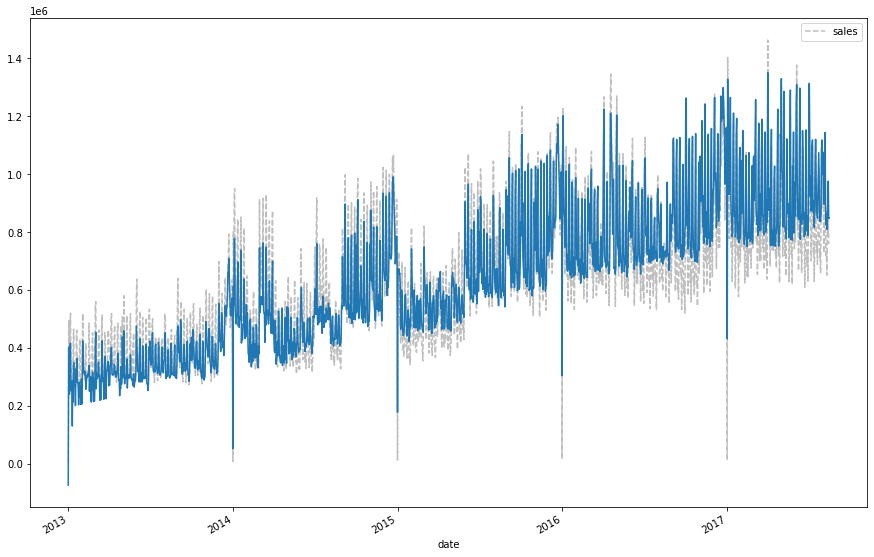

In [86]:
fig, ax = plt.subplots(figsize=(15,10))
df_sum_date.plot(ax=ax,linestyle='dashed',color="0.75")
y_pred_boosted_2.plot(ax=ax)

In [87]:
#MSEで評価
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_deseason_gbm, y_pred_gbm))
print(mean_squared_error(y_deseason_xgb, y_pred_xgb))

6396372994.934539
1736977299.5758069


## Forecasting With Machine Learning

In [88]:
df_train['family'].nunique()

33

In [89]:
store_sales = df_train.copy()
#store_sales = store_sales.drop(['onpromotion','id',], axis=1)
#store_sales = store_sales.groupby(['family','date']).sum()
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

In [90]:
store_nbr_1=store_sales.loc[1,:].drop(['id','onpromotion'], axis=1).unstack('family')
store_nbr_1

sales                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                 ...                       \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES      MEATS   
date                                             ...                        
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0    0.00000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  369.10100   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  272.31900   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  454.17200   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  328.94000   
...                ...      ...    ...      ...  ...       ...        ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       4.0  385.99402   
2017-08-12         3.0    351.0  526.0   99.488  ...       6.0  211.75600   
2017-08-13         1.0    169.0  266.0   47.770  ...       4.0   88.18200   
2017-08-14         4.0    571.0  699.0  154.578  ...       8.0  192.76300   
2017-08-15        21.0    703.0  602.0  116.402  ...       3.0  274.17600   

                                                                          \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2013-01-01           0.0          0.0                     0.0    0.00000   
2013-01-02         194.0          0.0                     0.0  247.29700   
2013-01-03         153.0          0.0                     0.0  187.27800   
2013-01-04          88.0          0.0                     0.0  258.02300   
2013-01-05         141.0          0.0                     0.0  212.33301   
...                  ...          ...                     ...        ...   
2017-08-11          53.0          5.0                     3.0  259.11800   
2017-08-12         227.0          3.0                     6.0  217.66400   
2017-08-13          45.0          2.0                     0.0  115.75800   
2017-08-14         159.0          3.0                     6.0  270.04700   
2017-08-15         173.0          3.0                    21.0  234.89200   

                                                                           
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                       
2013-01-01       0.000000     0.000                        0.0   0.000000  
2013-01-02      47.000000     0.000                        0.0  38.029000  
2013-01-03      63.000000     0.000                        0.0  17.366001  
2013-01-04      67.000000     0.000                        0.0  29.907001  
2013-01-05      66.000000     0.000                        0.0  24.842000  
...                   ...       ...                        ...        ...  
2017-08-11      24.963001  1115.334                        0.0  19.424000  
2017-08-12      48.058000  1762.493                        0.0  20.150000  
2017-08-13      20.346000   986.669      

In [91]:
store_nbr_1['sales','AUTOMOTIVE']
#store_nbr_1.shift(1)

date
2013-01-01    0.0
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
             ... 
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0
Name: (sales, AUTOMOTIVE), Length: 1684, dtype: float64

In [92]:
#これは使わない
#def make_multistep_target(ts, steps):
    #for i in range(steps):
        #return pd.concat([ts.shift(-i)], axis=1)

In [93]:
#step_targetを作成（time dummyではなく、何ステップ先を予測したいかに使う）
def make_multistep_target(ts, steps):
    return pd.concat([ts.shift(-i-1) for i in range(steps)], axis=1)

In [94]:
display(store_sales)
make_multistep_target(store_sales, steps=3)#.dropna()

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

id  sales  onpromotion         id  \
store_nbr family     date                                                   
1         AUTOMOTIVE 2013-01-01     1782.0    2.0          0.0     3564.0   
                     2013-01-02     3564.0    3.0          0.0     5346.0   
                     2013-01-03     5346.0    3.0          0.0     7128.0   
                     2013-01-04     7128.0    5.0          0.0     8910.0   
                     2013-01-05     8910.0    2.0          0.0    10692.0   
...                                    ...    ...          ...        ...   
54        SEAFOOD    2017-08-11  2995409.0    1.0          1.0  2997191.0   
                     2017-08-12  2997191.0    2.0          0.0  2998973.0   
                     2017-08-13  2998973.0    0.0          0.0  3000755.0   
                     2017-08-14  3000755.0    3.0          0.0        NaN   
                     2017-08-15        NaN    NaN          NaN        NaN   

                                 sales  onpromotion         id  sales  \
store_nbr family     date                                               
1         AUTOMOTIVE 2013-01-01    3.0          0.0     5346.0    3.0   
                     2013-01-02    3.0          0.0     7128.0    5.0   
                     2013-01-03    5.0          0.0     8910.0    2.0   
                     2013-01-04    2.0          0.0    10692.0    0.0   
                     2013-01-05    0.0          0.0    12474.0    2.0   
...                                ...          ...        ...    ...   
54        SEAFOOD    2017-08-11    2.0          0.0  2998973.0    0.0   
                     2017-08-12    0.0          0.0  3000755.0    3.0   
                     2017-08-13    3.0          0.0        NaN    NaN   
                     2017-08-14    NaN          NaN        NaN    NaN   
                     2017-08-15    NaN          NaN        NaN    NaN   

                                 onpromotion  
store_nbr family     date                     
1         AUTOMOTIVE 2013-01-01          0.0  
                     2013-01-02          0.0  
                     2013-01-03          0.0  
                     2013-01-04          0.0  
                     2013-01-05          0.0  
...                                      ...  
54        SEAFOOD    2017-08-11          0.0  
                     2017-08-12          0.0  
                     2017-08-13          NaN  
                     2017-08-14          NaN  
                     2017-08-15          NaN  

[3000888 rows x 9 columns]

In [95]:
#family_sales = (store_sales.groupby(['family', 'date']).mean().unstack('family').loc['2017'])

## 予測

In [96]:
import datetime as dt

In [97]:
sales = df_train.copy()
sales['date'] = sales.date.dt.to_period('D')
sales=sales.set_index(['store_nbr','family','date']).sort_index()
display(sales)
family_sales=(sales.groupby(['family','date']).mean().unstack('family').loc['2017'])

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

In [98]:
#family_sales.loc[:,'sales']
family_sales.loc[:,'sales'].stack('family')

date        family                    
2017-01-01  AUTOMOTIVE                       0.092593
            BABY CARE                        0.037037
            BEAUTY                           0.055556
            BEVERAGES                       74.222222
            BOOKS                            0.000000
                                             ...     
2017-08-15  POULTRY                        325.679815
            PREPARED FOODS                  85.954129
            PRODUCE                       2316.832796
            SCHOOL AND OFFICE SUPPLIES      46.851852
            SEAFOOD                         17.966241
Length: 7491, dtype: float64

In [99]:
#def make_multistep_target(ts, steps):
    #return pd.concat([ts.shift(-i) for i in range(steps)], axis=1)
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [100]:
#def make_lags(ts, lags):
    #return pd.concat([ts.shift(i+1) for i in range(lags)], axis=1)
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [101]:
y = family_sales.loc[:,'sales']
#make4 lag features
X = make_lags(y, lags=5).dropna()
y= make_multistep_target(y, steps=16).dropna()
#y,Xの共通行（日時）のみを残す
y, X = y.align(X, join='inner', axis=0)

In [102]:
X #ラグ特徴量1～5
y

y_step_1                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-06   6.018519  0.277778   6.518519  3507.277778  0.537037   
2017-01-07  10.259259  0.259259  10.037037  4848.518519  0.481481   
2017-01-08   9.388889  0.240741  11.611111  5503.648148  0.722222   
2017-01-09   5.944444  0.444444   5.648148  3448.203704  0.500000   
2017-01-10   4.777778  0.240741   6.500000  3171.740741  0.518519   
...               ...       ...        ...          ...       ...   
2017-07-27   6.277778  0.240741   3.981481  2623.814815  0.037037   
2017-07-28   6.370370  0.166667   4.092593  3554.111111  0.000000   
2017-07-29  10.018519  0.203704   7.185185  4612.685185  0.000000   
2017-07-30   9.796296  0.259259   8.388889  5074.629630  0.018519   
2017-07-31   6.685185  0.314815   5.111111  3620.444444  0.018519   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-06   513.873278   18.333333  1257.611111   864.333333  317.622407   
2017-01-07   649.424130   21.444444  1761.351852  1173.462963  381.874741   
2017-01-08   776.717815   10.925926  1784.018519  1323.314815  429.561796   
2017-01-09   535.816019    9.240741  1208.018519   883.685185  284.767444   
2017-01-10   493.187685   15.814815  1102.685185   790.740741  256.885019   
...                 ...         ...          ...          ...         ...   
2017-07-27   411.163463   19.222222  1395.314815   623.944444  213.962722   
2017-07-28   493.264759   16.666667  1548.685185   764.481481  335.682259   
2017-07-29   596.895371   19.500000  1906.611111   983.037037  354.486481   
2017-07-30   701.206278   10.833333  2107.722222  1100.592593  395.133315   
2017-07-31   562.624685    8.629630  1655.277778   860.981481  308.857685   

            ...  y_step_16                                         \
family      ...  MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-06  ...  10.444444  402.395259    420.944444    11.314815   
2017-01-07  ...   8.648148  413.076537    462.462963    12.462963   
2017-01-08  ...   7.037037  310.008519    311.888889     6.962963   
2017-01-09  ...   5.259259  300.459296    323.500000     5.814815   
2017-01-10  ...   6.222222  286.084260    297.462963     5.759259   
...         ...        ...         ...           ...          ...   
2017-07-27  ...   9.259259  498.964667    295.888889    10.870370   
2017-07-28  ...   8.944444  329.178706    294.500000     9.407407   
2017-07-29  ...   8.685185  345.055834    336.814815    10.018519   
2017-07-30  ...   8.462963  314.364556    279.203704     7.722222   
2017-07-31  ...   8.537037  332.003166    273.833333     6.740741   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-06               16.148148  489.485851     143.066296  2849.252981   
2017-01-07               18.351852  525.847129     141.927852  3101.657620   
2017-01-08               11.518519  370.790056      97.506241  2168.730113   
2017-01-09                9.370370  326.745629      97.317222  2247.617905   
2017-01-10                8.888889  328.241963     104.017889  2869.711257   
...                            ...         ...            ...          ...   
2017-07-27               12.111111  468.857370      96.286926  2198.854500   
2017-07-28               13.185185  354.342779      84.693815  2070.154646   
2017-07-29               13.722222  379.801204      91.509426  2331.922267   
2017-07-30                9.259259  344.398297      86.062500  2

In [103]:
y = family_sales.loc[:,'sales']
#make4 lag features
X = make_lags(y, lags=5).dropna()
y= make_multistep_target(y, steps=16).dropna()
y, X = y.align(X, join='inner', axis=0)

le = LabelEncoder()
#X.stack('family').reset_index() これにしてはいけない理由
X=(X.stack('family').reset_index('family'))

In [104]:
X['family']=le.fit_transform(X['family'])
X

,family,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date,,,,,,
2017-01-06,0,6.333333,6.833333,8.296296,11.481481,0.092593
2017-01-06,1,0.351852,0.333333,0.296296,0.259259,0.037037
2017-01-06,2,5.925926,6.888889,7.185185,11.648148,0.055556
2017-01-06,3,3258.796296,3911.833333,4507.814815,6208.055556,74.222222
2017-01-06,4,0.407407,0.759259,0.814815,0.481481,0.000000
...,...,...,...,...,...,...
2017-07-31,28,464.615647,416.242072,528.171893,269.486870,306.457167
2017-07-31,29,101.991167,100.165148,87.455833,77.199741,82.526278
2017-07-31,30,2704.551759,2444.234481,2073.127593,1675.579372,2702.183687


In [105]:
y=y.stack('family')
y

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.018519    10.259259     9.388889   
           BABY CARE                      0.277778     0.259259     0.240741   
           BEAUTY                         6.518519    10.037037    11.611111   
           BEVERAGES                   3507.277778  4848.518519  5503.648148   
           BOOKS                          0.537037     0.481481     0.722222   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.944444     4.777778     6.314815   
           BABY CARE                      0.444444     0.240741     0.277778   
           BEAUTY                         5.648148     6.500000     5.277778   
           BEVERAGES                   3448.203704  3171.740741  3046.870370   
           BOOKS                          0.500000     0.518519     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.388889     5.240741     8.500000   
           BABY CARE                      0.296296     0.296296     0.388889   
           BEAUTY                         4.370370     4.703704     7.777778   
           BEVERAGES                   2693.722222  3226.037037  4667.296296   
           BOOKS                          0.388889     0.444444     0.574074   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596557   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                    10.259259     6.407407     5.685185   
           BABY CARE                      0.425926     0.314815     0.166667   
           BEAUTY                         9.037037     5.648148     5.351852   
           BEVERAGES                   5580.611111  3700.370370  3409.796296   
           BOOKS                          0.555556     0.388889     0.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270204   278.819870   468.857370   
           PREPARED FOODS                84.796537    78.791444    96.286926   
           PRODUCE                     2663.076241  1670.264889  2198.854500   
           SCHOOL AND OFFICE SUPPLIES  

### Direct strategy

In [112]:
from sklearn.multioutput import MultiOutputRegressor
model_chain = MultiOutputRegressor(XGBRegressor())
model_chain.fit(X,y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
     

In [114]:
y_pred_chain = model_chain.predict(X)
y_pred_chain

array([[6.8253140e+00, 6.4363427e+00, 6.0459075e+00, ..., 6.2839203e+00,
        6.9128199e+00, 6.4747968e+00],
       [9.3539876e-01, 9.5624971e-01, 9.1809160e-01, ..., 8.6733174e-01,
        7.7477551e-01, 1.3758962e+00],
       [6.8253140e+00, 5.5901628e+00, 6.9541855e+00, ..., 6.2839203e+00,
        6.9128199e+00, 6.1144481e+00],
       ...,
       [2.2316980e+03, 2.4928513e+03, 3.1017026e+03, ..., 2.4136995e+03,
        2.1058848e+03, 2.1592651e+03],
       [2.5759268e+01, 3.2352924e+01, 3.0681656e+01, ..., 3.2104023e+01,
        3.1878061e+01, 3.5087547e+01],
       [2.2643187e+01, 2.0843262e+01, 1.9205746e+01, ..., 2.5693497e+01,
        2.1540606e+01, 1.8150707e+01]], dtype=float32)

In [116]:
y_pred_chain=pd.DataFrame(model_chain.predict(X), index=y.index, columns=y.columns)
y_pred_chain

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.825314     6.436343     6.045907   
           BABY CARE                      0.935399     0.956250     0.918092   
           BEAUTY                         6.825314     5.590163     6.954185   
           BEVERAGES                   3497.541748  4814.229492  5505.193359   
           BOOKS                          0.935399     0.956250     0.918092   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      339.155914   313.091949   330.074982   
           PREPARED FOODS                96.618530    94.159653    84.856125   
           PRODUCE                     2231.697998  2492.851318  3101.702637   
           SCHOOL AND OFFICE SUPPLIES    25.759268    32.352924    30.681656   
           SEAFOOD                       22.643187    20.843262    19.205746   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     7.301438     7.659491     7.072208   
           BABY CARE                      0.902181     1.096083     0.788219   
           BEAUTY                         7.301438     6.526452     6.676960   
           BEVERAGES                   3452.213135  3175.459961  3044.581787   
           BOOKS                          0.902181     1.373250     0.788219   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      287.584595   533.793457   443.530884   
           PREPARED FOODS                81.484825    85.749779   100.771416   
           PRODUCE                     1786.841797  2094.793213  2440.005859   
           SCHOOL AND OFFICE SUPPLIES    37.283543    52.659412    53.351414   
           SEAFOOD                       12.972900    25.203699    25.672621   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.072971     6.863771     8.236042   
           BABY CARE                      0.856364     0.929429     1.224262   
           BEAUTY                         6.072971     6.012934     8.236042   
           BEVERAGES                   2694.216553  3211.039307  4656.245117   
           BOOKS                          0.856364     0.929429     1.224262   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      461.595367   358.388458   322.850555   
           PREPARED FOODS               105.524467    96.996918    86.727440   
           PRODUCE                     2781.697510  2070.109619  2201.631104   
           SCHOOL AND OFFICE SUPPLIES    43.799824    43.518951    37.192982   
           SEAFOOD                       27.493530    23.667442    21.341095   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     9.340393     7.851576     7.124057   
           BABY CARE                      0.752006     0.622015     0.678930   
           BEAUTY                         9.340393     7.851576     6.781717   
           BEVERAGES                   5581.268066  3714.344971  3411.247314   
           BOOKS                          0.752006     0.622015     0.678930   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      325.114624   288.299622   531.903320   
           PREPARED FOODS                86.440605    81.819206    87.524475   
           PRODUCE                     2725.049561  1747.265381  2179.728027   
           SCHOOL AND OFFICE SUPPLIES  

In [122]:
submission=pd.read_csv('submission-Copy1.csv')
submission

,id,sales
0,3000888,4.274030
1,3000889,0.000000
2,3000890,3.495530
3,3000891,2414.541711
4,3000892,0.438314
...,...,...
28507,3029395,372.417153
28508,3029396,107.843530
28509,3029397,1273.316507
28510,3029398,44.945937


In [147]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [134]:
df_fore=pd.merge(submission,df_test, on='id')
df_fore

,id,sales,date,store_nbr,family,onpromotion
0,3000888,4.274030,2017-08-16,1,AUTOMOTIVE,0
1,3000889,0.000000,2017-08-16,1,BABY CARE,0
2,3000890,3.495530,2017-08-16,1,BEAUTY,2
3,3000891,2414.541711,2017-08-16,1,BEVERAGES,20
4,3000892,0.438314,2017-08-16,1,BOOKS,0
...,...,...,...,...,...,...
28507,3029395,372.417153,2017-08-31,9,POULTRY,1
28508,3029396,107.843530,2017-08-31,9,PREPARED FOODS,0
28509,3029397,1273.316507,2017-08-31,9,PRODUCE,1
28510,3029398,44.945937,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [142]:
a=df_fore.set_index(['store_nbr','family','date'])

In [149]:
b=a.groupby(['family','date']).mean().loc[:,'sales']

In [154]:
b=pd.DataFrame(b, columns=['sales'])
b

sales
family     date                 
AUTOMOTIVE 2017-08-16   5.909883
           2017-08-17   5.915429
           2017-08-18   6.346073
           2017-08-19   9.523180
           2017-08-20   9.393172
...                          ...
SEAFOOD    2017-08-27  23.289737
           2017-08-28  15.993870
           2017-08-29  15.172385
           2017-08-30  17.791260
           2017-08-31  16.107949

[528 rows x 1 columns]